# Example Notebook for Network Visualization

### Change working directory to this root

In [1]:
import os
os.chdir("..")

### Imports

In [2]:
import random

import torch
import matplotlib.pyplot as plt
import torchaudio
import IPython

from common import registry
from utils.config import load_cfg_from_hydra
from utils.containers import MelSpecParameters
from models.mel_spec_converters import SimpleMelSpecConverter

/home/vovatch/anaconda3/envs/BPM/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load model

In [3]:
# weights path
weights_path = "weights/tokenizer_best.ckpt"

# Infer device
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Current device is {device}")

# Load network
cfg = load_cfg_from_hydra(config_path="../config", config_name="config")
cfg.learning.batch_size = 128
cfg.learning.val_split = 1.0 # Will it let me do that?
model = registry.get_lightning_module(cfg.model.module_type).from_cfg(cfg, weights_path).to(device).eval()

Current device is cpu


### Load data loader

In [4]:
dataset = registry.get_dataset(cfg.dataset.dataset_type).from_cfg(cfg)
dataset_len = len(dataset)
slice_len = 128

# Select a random sample
sample_start = random.randint(0, dataset_len - slice_len - 1)
dataset_slice = dataset[sample_start: sample_start + slice_len] # type: ignore
concatenated_slice = torch.cat(dataset_slice["slice"], dim=1)

print(f"The concatenated slice dimensions are {concatenated_slice.shape}")

Parsing slices to buffer...: 100%|██████████| 2/2 [00:00<00:00, 16.29it/s]

Parsed metadata and the slices to the buffer
The concatenated slice dimensions are torch.Size([1, 131072])


### WAV Player element

In [5]:
# this is a wrapper that take a filename and publish an html <audio> tag to listen to it

def wavPlayer(filepath):
    """ will display html 5 player for compatible browser

    Parameters :
    ------------
    filepath : relative filepath with respect to the notebook directory ( where the .ipynb are not cwd)
                of the file to play

    The browser need to know how to play wav through html5.

    there is no autoplay to prevent file playing when the browser opens
    """
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
        <source src="files/%s" type="audio/mp3" />
        Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))

### Initialize Mel-Spectrogram Converter

In [6]:
n_mels = 32
mel_spec_params = MelSpecParameters(n_fft=1024, f_min=20, hop_length=32, n_mels=n_mels, power=1.0, pad=0)
mel_spec_converter = SimpleMelSpecConverter(mel_spec_params)

lin_vector = torch.linspace(
    0.5,
    10,
    n_mels,
)
eye_mat = torch.diag(lin_vector).to(device)

### Load data point and visualize it

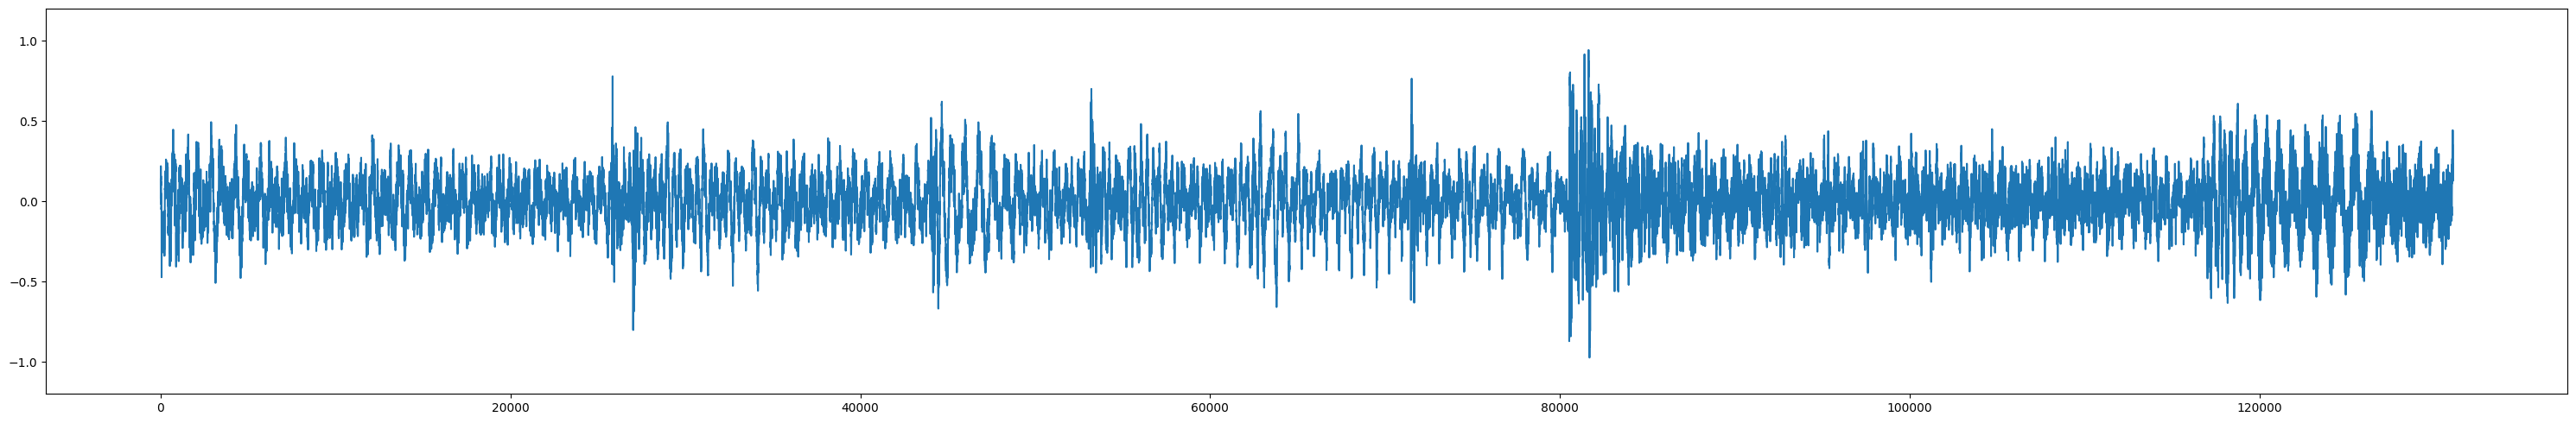

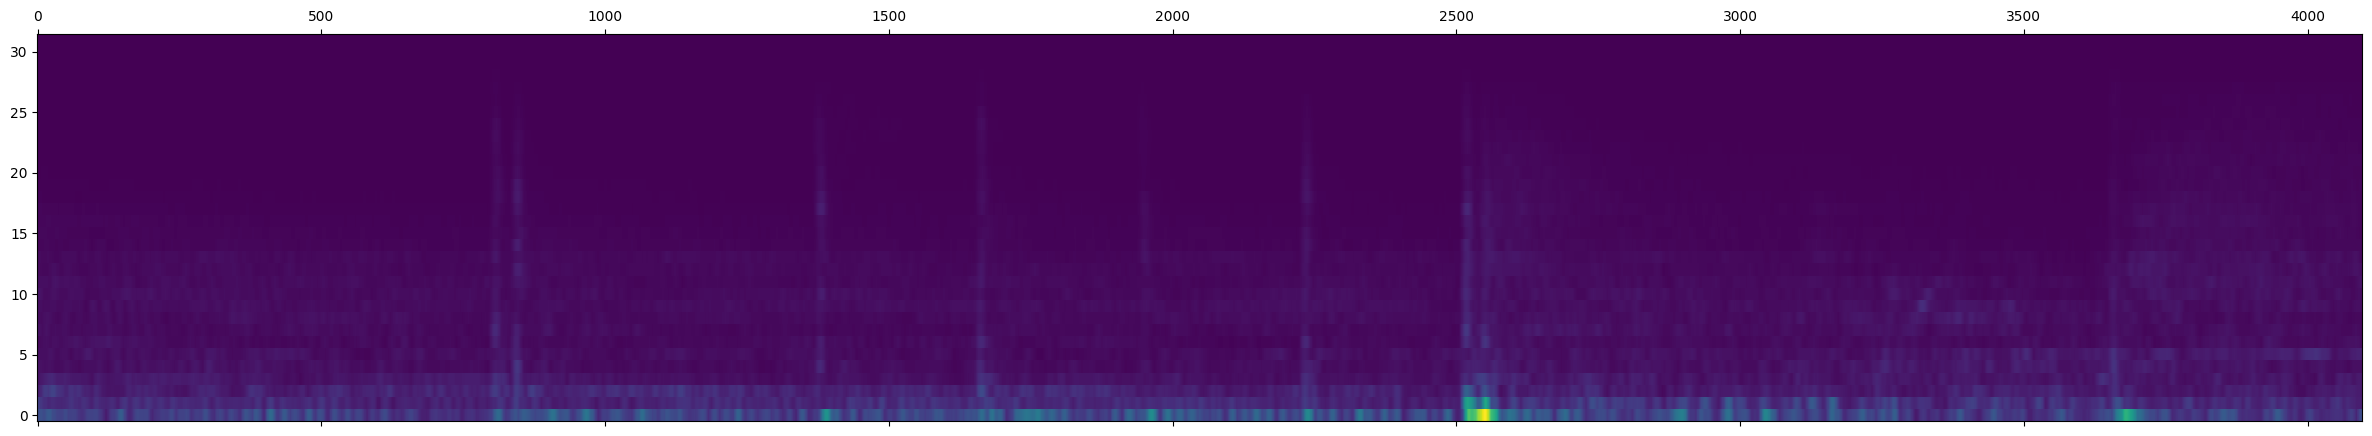

In [7]:
image_reshaped = concatenated_slice.flatten().cpu().numpy() # type: ignore

plt.figure(figsize=(30, 5))
plt.plot(image_reshaped)

plt.tight_layout()
plt.ylim(-1.2, 1.2)
plt.show()

plt.figure(figsize=(30, 5))
plt.matshow(mel_spec_converter.convert(torch.tensor(image_reshaped)).cpu().numpy(), origin='lower', fignum=1, aspect='auto')
plt.show()

torchaudio.save('sample.mp3', concatenated_slice.cpu().detach(), 44100, format='mp3') # type: ignore
IPython.display.Audio(filename="sample.mp3") # type: ignore

## Inference

### Perform inference

torch.Size([128, 1, 1024])
tensor(0.0227)


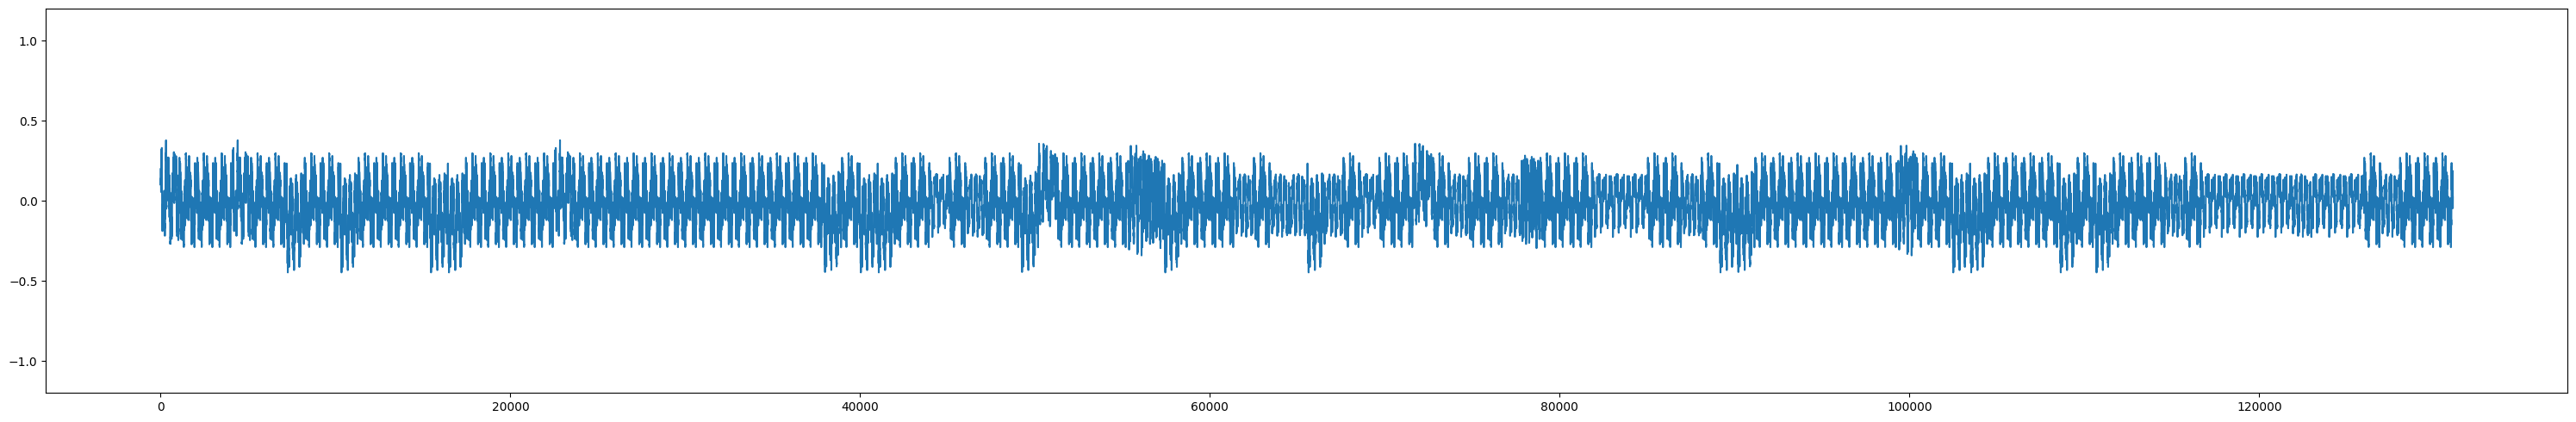

/tmp/ipykernel_189177/1390101189.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.matshow(mel_spec_converter.convert(torch.tensor(reconstructed_slice["slice"].flatten())).cpu().numpy(), origin='lower', fignum=1, aspect='auto')


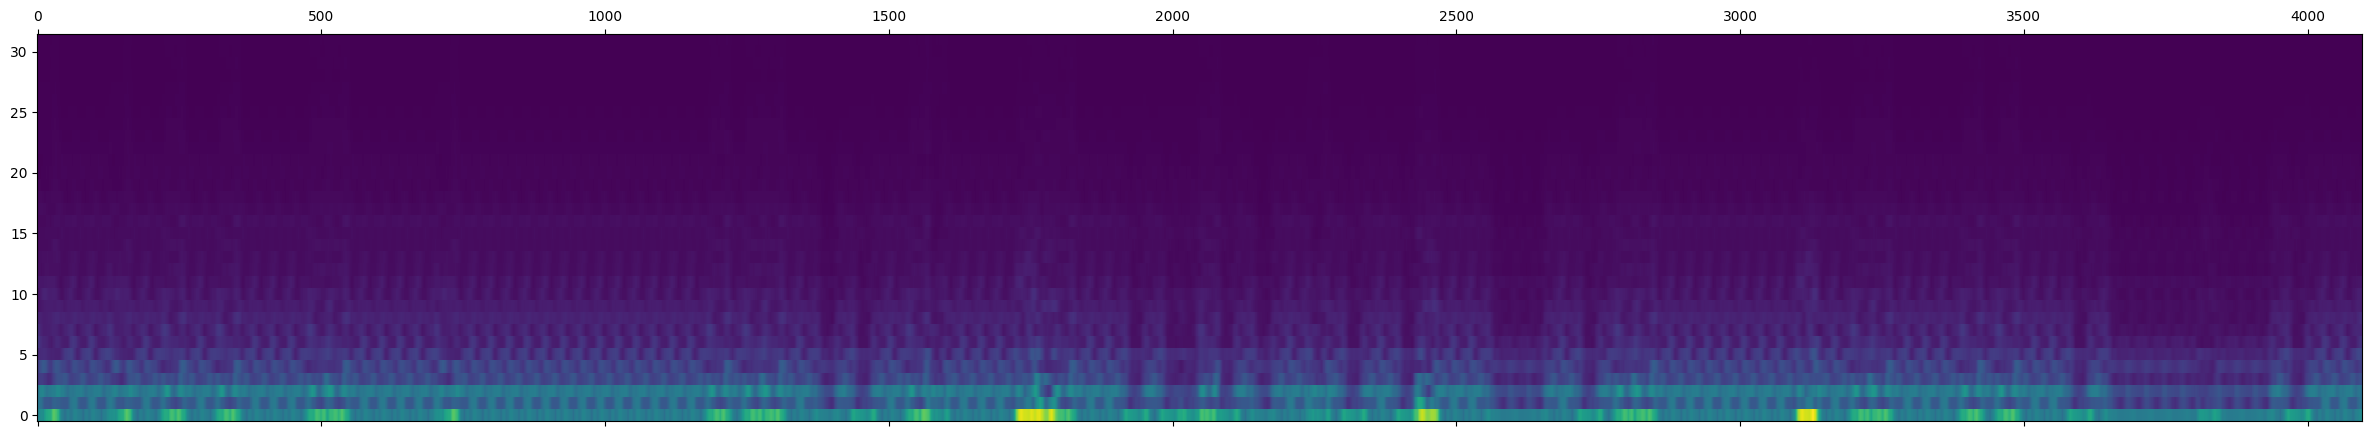

In [8]:
collated_batch = {key: torch.stack(value, dim=0).to(device) for (key, value) in dataset_slice.items() if key == "slice"}
print(collated_batch["slice"].shape)
with torch.no_grad():
    reconstructed_slice = model(collated_batch)
    
reconstructed_slice_flattened = reconstructed_slice["slice"].flatten().cpu().detach()
print(torch.nn.functional.smooth_l1_loss(reconstructed_slice["slice"].flatten().unsqueeze(0).to('cpu'), concatenated_slice.to("cpu")))

plt.figure(figsize=(30, 5))
plt.plot(reconstructed_slice_flattened)

plt.tight_layout()
plt.ylim(-1.2, 1.2)
plt.show()

plt.figure(figsize=(30, 5))
plt.matshow(mel_spec_converter.convert(torch.tensor(reconstructed_slice["slice"].flatten())).cpu().numpy(), origin='lower', fignum=1, aspect='auto')
plt.show()

torchaudio.save('sample.mp3', reconstructed_slice["slice"].flatten().unsqueeze(0).cpu().detach(), 44100, format='mp3') # type: ignore
IPython.display.Audio(filename="sample.mp3") # type: ignore



### Compare mel specs of a single 1024 length slice

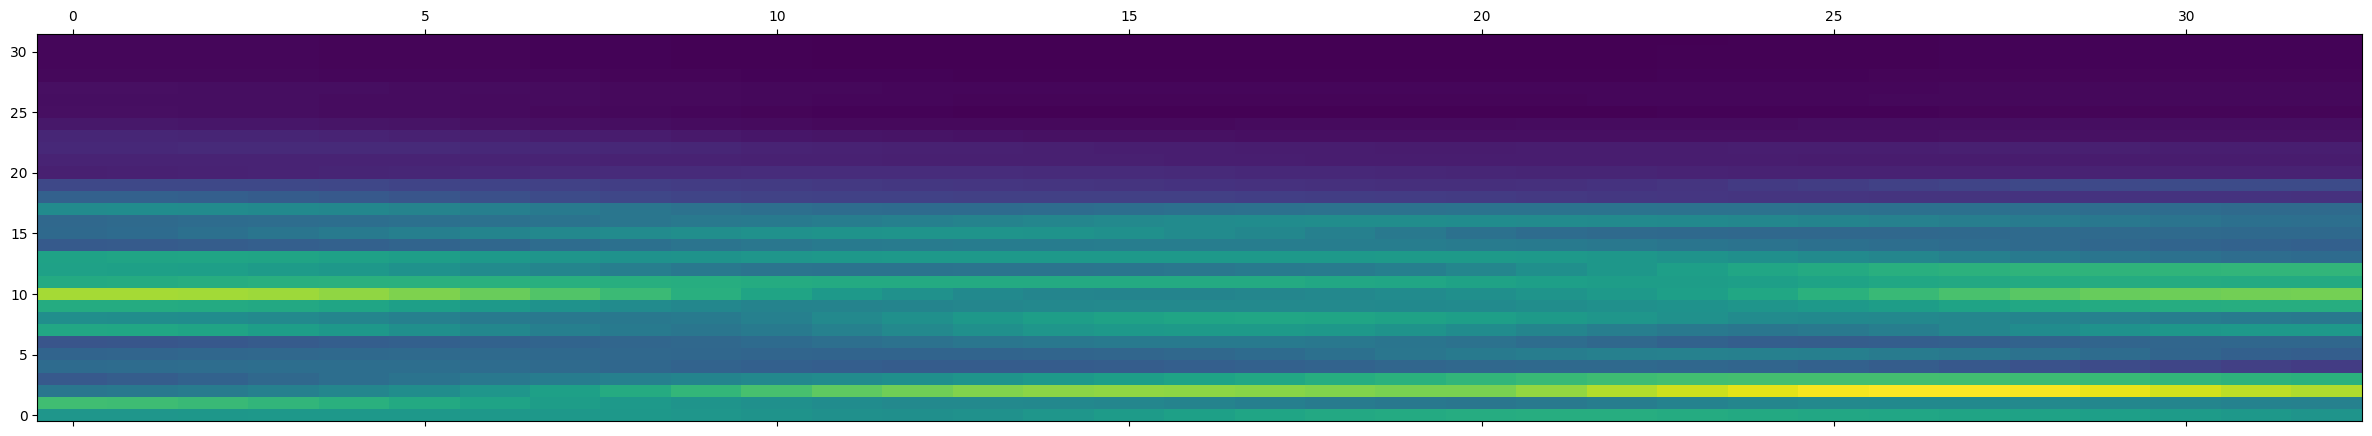

/tmp/ipykernel_189177/2784421738.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (eye_mat @ mel_spec_converter.convert(torch.tensor(reconstructed_single_sample["slice"].flatten()))).cpu().numpy(), origin='lower', fignum=1, aspect='auto'


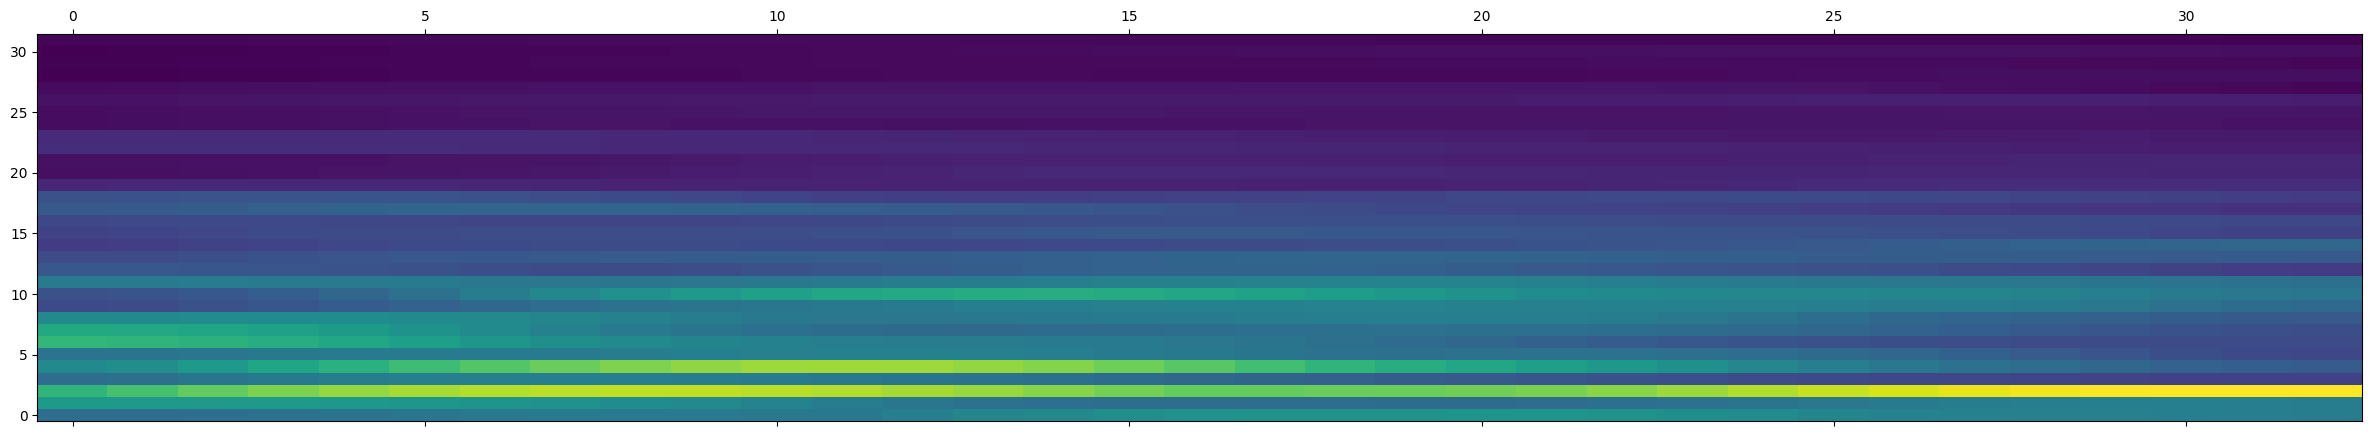

In [9]:
single_sample = dataset[sample_start]
collated_sample = {key: torch.stack((value,), dim=0).to(device) for (key, value) in single_sample.items() if key == "slice"}

with torch.no_grad():
    reconstructed_single_sample = model(collated_sample)
    
plt.figure(figsize=(30, 5))
plt.matshow((eye_mat @ mel_spec_converter.convert(collated_sample["slice"].flatten())).cpu().numpy(), origin='lower', fignum=1, aspect='auto')
plt.show()

plt.figure(figsize=(30, 5))
plt.matshow(
    (eye_mat @ mel_spec_converter.convert(torch.tensor(reconstructed_single_sample["slice"].flatten()))).cpu().numpy(), origin='lower', fignum=1, aspect='auto'
)
plt.show()